```
By Svitlana Midianko
Spring 2021
```

# Table of contents (clickable in NB format)

* 0. [Introduction and problem definition](#intro)
* 1. [Executive summary of the proposed solution](#execsum)
* 2. [Implementation of the solution](#imp)
    * 2.1. [Data loading and pre-processing](#first)
        * 2.1.2 [Pre-processing each of the features](#2.2.)
    * 2.2. **[Modeling regression](#modeling)**
        * 2.2.1. [Random forest - hyperparameter tuning](#rftuning)
        * 2.2.2. [Random forest + PCA (with tuned hyperparameters)](#rfbasicpca)
        * 2.2.3. [Support Vector Machines - hyperparameter tuning](#svmhyper)
        * 2.2.4. [Support Vector Machines + PCA (with tuned hyperparameters)](#svmhyperpca)
        * 2.2.5. [SUMMARY](#sum1)
    * 2.3. **[Modeling classification](#modeling2)**
        * 2.3.1. [Random forest - hyperparameter tuning](#r_clf)
        * 2.3.2. [Random forest + PCA (with tuned hyperparameters)](#rfbasicpca_clf)
        * 2.3.3. [Support Vector Machines - hyperparameter tuning](#svmhyper_clf)
        * 2.3.4. [Support Vector Machines + PCA (with tuned hyperparameters)](#svmhyperpca_clf)
        * 2.3.5. [SUMMARY](#sum1_clf)
* 3. [Summary](#summaryfinal)
* [Appendix](#appendix)
    * [Appendix A. Dealing with inbalance - undersampling the majority](#inbalance)
    * [Appendix B. Dealing with inbalance - undersampling the majority (with PCA)](#inbalance2)
    * [Appendix C. Random forest basic](#rfbasic)
    * [Appendix D. Support Vector Machines basic](#svm)


*Note: unfortunately Latex did not export this table:(. Sorry for this. It works in JN.*

# 0. Introduction and problem definition 
<a id = 'intro' class = 'anchor'></a>
As of now, there exist more than 3.1M mobile apps solely on Google Play Market ([Statista, 2020](https://www.statista.com/statistics/276623/number-of-apps-available-in-leading-app-stores/#:~:text=What%20are%20the%20biggest%20app,million%20available%20apps%20for%20iOS.)). Together with the ones available in iOS App Store, these applications generate almost $32B of revenue, making it a desirable market for many founders ([D. Curry, 2021](https://www.alliedmarketresearch.com/mobile-application-market#:~:text=The%20global%20mobile%20application%20market,18.4%25%20from%202019%20to%202026.)). Having read about these positive trends, I got myself wondering - how many of these 3.1m mobile apps become successful? [Gartner study](https://www.businessofapps.com/insights/top-reasons-why-mobile-apps-fail-to-make-a-mark-in-the-market/) reveals that only 0.01% of the apps reach commercial success.
<br> 
With the above in mind, I decided to take a data-driven approach to explore the following questions: 
1. What features define a successful mobile application? Can I use ML to predict the app's ratings?
2. Can I use ML to predicting the app's success before launch?
<br>

I approach these questions with a user-centered mind - that is, the application's success is defined by the average rating that the application has or/and the number of installs. 

---

# 1. Executive summary of the proposed solution <a id = 'intro' class = 'execsum'></a>
To answer these questions, I will use the dataset that was [published on Kaggle by L. Gupta (2018).](https://www.kaggle.com/lava18/google-play-store-apps). This dataset was scraped from Google Play Market and resulted in two datasets: (1) features of the apps, such as ratings, installs, category; (2) actual user reviews in text. For this project, I will only use the first dataset, however, the second one could serve as a great complement to quantitive analysis and might be performed sometime in the future. 


I divide this overarching problem into two separate modeling processes. One being **regression modeling** ("What is the rating of the app, given these features?"), and the other being **classification** ("Would this application be successful given these *pre-launch* features?"). 


For both of the processes, I use the same ML methods because: 
(a) using the same models will allow me to compare the methods in two different kinds of the problem (regression VS classification), which yields the highest learning opportunity for me; 
(b) these methods make sense in the given context (explained below).

1. **Random Forest Model (RFM)** - will provide a great insight into what are the specific features defining the success of the application and their degree of influence. RFM does not make any assumptions about underlying data, which is helpful in my context of highly variable and rich data ;
2. **Support Vector Machines (SVM)** - specifically SV Regression and SV Classification correspondingly. Because sparsity of the data is high (the `genres` categories are often 0s), SVMs would make the most out of it. Further, SVMs are [usually preffered](https://datascience.stackexchange.com/questions/9736/what-kinds-of-learning-problems-are-suitable-for-support-vector-machines) over neural nets in case of the smaller dataset, which is also our case.


Furthermore, I will compare the stand-alone models with those fitted on **PCA** reduced datasets. PCA will help me see if any components alone can do a job for all other components. Also, for each model, I perform a **4-fold CV grid search** to determine the best hyperparameters.  All the data is also **scaled** before fitting giving huge variaility.

---
# 2. Implementation of the solution <a id = 'intro' class = 'imp'></a>

## 2.1. Data loading and pre-processing 
<a class = 'anchor' id="first"></a>
Because all columns are initially of the type `object`, below, I will do pre-processing of each feature and convert them into necessary data types. Specifically, we have the following features and transformations performed (showed in the table below). 


| Feature name | What it describes | Pre-processing performed |
| --- | --- | --- |
| `Category`| application's category, such as 'family', 'books' etc. |  Since there is an exact overlap between `Genres` and `Category` features,`category` was dropped. |
| `Ratings` |average rating for an app| The NAs were dropped (1474 NAs), given that it is a dependent variable. Was converted to numeric.|
|`Reviews` |number of reviews that application has|Was converted to numeric.|
|`Size`| memory size of the application| Was converted and standardized to be in MB. `Varies with size` was replaced with NA.|
|`Installs`| number of times the application was installed | Was stripped and converted to numeric.|
| `Type` | free or paid application | String categories were replaced with 0 and 1s.|
|`Price` | price of the app| Was converted to numeric.|
|`Content Rating`| refers to who can download the application to manifest recommendations on, e.g., age| Was hot-encoded. |
|`Last Updated` | last date when application released an update | Dataset was subsetted based this to only include those apps that had *some* update in the last 1.5 years. The rationale here is that we only want to analyze the active apps, and such apps usually have at least some yearly update.|
|`Genres`| genre of the application. `Genres` encompass the same words as `Category` and more | Because the `genres` column has strings that consists of multiple tags, the separated tags were extracted and then hot-encoded for each application. If there were less than 40 applications of a specific genre, it was dropped.|


The initial size of the data was 10841. After cleaning and pre-processing, the dataset shrank in half, becoming more manageable for the low computational power given.

In [1]:
# importing necessary modules
# basics
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
# for pre-processing 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample
# for modeling
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import svm
from keras.models import Sequential
from keras.layers import Dense
# for model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, classification_report
# other
import warnings
warnings.filterwarnings("ignore")
np.random.seed(0)

Using TensorFlow backend.


In [2]:
path_ratings = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/ml-projec/code/Users/svitlana/Data/googleplaystore.csv'
ratings_raw = pd.read_csv(path_ratings, error_bad_lines=False)

In [3]:
# ratings_raw.info() # uncomment if you wish to see

In [4]:
ratings_raw.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


## 2.2. Pre-processing each of the features <a class = 'anchor' id = '2.2.'></a>
### `Category` pre-processing (will be later dropped because of the overlap with `genres`)

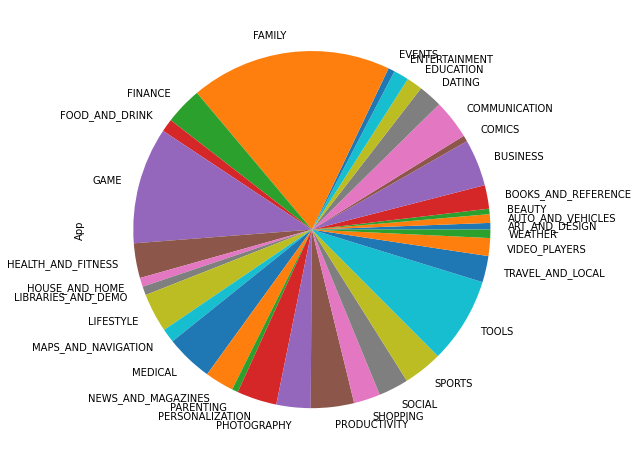

In [5]:
# there is some random category app with 1.9
# drop it
ratings_raw.drop(ratings_raw.loc[ratings_raw['Category']=='1.9'].index, inplace=True)
ratings_raw.groupby('Category').count().plot.pie(y = 'App', figsize = (8,12), legend = False)

In [6]:
len(np.unique(ratings_raw['Category'])) # 33 unique categories

33

Family, games, and tools are most popular. What are those 'tools' apps? These are usually referred as productivity tools, e.g. google calendar or sheets.

In [7]:
# ratings_raw[ratings_raw['Category'] == 'TOOLS'].head(5) # uncomment to see yourself. 

### `Rating` & `Reviews` pre-processing

In [8]:
ratings_raw["Rating"] = pd.to_numeric(ratings_raw["Rating"])
# let's take an exploratory look
print('\nRating')
print('  mean %f' % ratings_raw["Rating"].describe()['mean'])
print('  median %f' % np.median(ratings_raw["Rating"]))
print('  min max %f' % ratings_raw["Rating"].describe()['min'] ,ratings_raw["Rating"].describe()['max'])

print('\nReviews')
ratings_raw["Reviews"] = pd.to_numeric(ratings_raw["Reviews"])
print('  mean %f' % np.mean(ratings_raw["Reviews"]))
print('  median %f' % np.median(ratings_raw["Reviews"]))
print('  min max %f' % min(ratings_raw["Reviews"]) ,max(ratings_raw["Reviews"]))


Rating
  mean 4.191757
  median nan
  min max 1.000000 5.0

Reviews
  mean 444152.896033
  median 2094.000000
  min max 0.000000 78158306


In [9]:
print(ratings_raw['Rating'].isnull().sum())
ratings_raw = ratings_raw.dropna(subset = ['Rating'])

1474


### `Size` pre-processing

In [10]:
# We need to do conversions on the size feature. 
# 1. convert all to MB
# 2. replace 'varies with size' with nan

# below we will subset each of the possible unit sizes, then do conversion
# and concatanate the separated datasets.
ratings_raw['Size']=ratings_raw['Size'].replace('Varies with device',np.nan)

mask = ratings_raw[ratings_raw['Size'].str.contains('k',  na=False)]
mask['Size']  = mask['Size'].str.replace('k','')
mask["Size"] = pd.to_numeric(mask["Size"])
mask['SizeMB']  = mask['Size']/1024

mask2 = ratings_raw[ratings_raw['Size'].str.contains('M',  na=False)]
mask2['Size']  = mask2['Size'].str.replace('M','')
mask2["Size"] = pd.to_numeric(mask2["Size"])
mask2['SizeMB']  = mask2["Size"] 

mask3 = ratings_raw[ratings_raw['Size'].isna()]
ratings = pd.concat([mask, mask2, mask3])

### `Installs` pre-processing

In [11]:
# next, the installs are numbers but recorded like strings
# --> convert to numbers
ratings["Installs"] =ratings["Installs"].str.replace('+', "")
ratings["Installs"] =ratings["Installs"].str.replace(',', "")
ratings["Installs"] =pd.to_numeric(ratings["Installs"])

###  `Type` pre-processing


In [12]:
# continuing our exploration
ratings['Type'] = ratings['Type'].replace('Free', 0)
ratings['Type'] = ratings['Type'].replace('Paid', 1)
ratings.groupby(['Type']).count()
# wow, this is a lot of free apps! 

,Android Ver,App,Category,Content Rating,Current Ver,Genres,Installs,Last Updated,Price,Rating,Reviews,Size,SizeMB
Type,,,,,,,,,,,,,
0,8718,8719,8719,8719,8716,8719,8719,8719,8719,8719,8719,7150,7150
1,646,647,647,647,646,647,647,647,647,647,647,579,579


### `Price` pre-processing

In [13]:
# similar to installs, price needs to be int
ratings["Price"] =ratings["Price"].str.replace('$', "")
ratings["Price"] =pd.to_numeric(ratings["Price"])

In [14]:
# exploration continues
# ratings["Price"].describe()

In [15]:
# I am curious to see what 400$ *most expensive* app is
ratings[ratings['Price'] == 400.0]
# oh well.

,Android Ver,App,Category,Content Rating,Current Ver,Genres,Installs,Last Updated,Price,Rating,Reviews,Size,SizeMB,Type
4367,4.1 and up,I'm Rich - Trump Edition,LIFESTYLE,Everyone,1.0.1,Lifestyle,10000,"May 3, 2018",400.0,3.6,275,7.3,7.3,1


### `Content Rating` pre-processing

In [16]:
ratings.groupby('Content Rating').count()

,Android Ver,App,Category,Current Ver,Genres,Installs,Last Updated,Price,Rating,Reviews,Size,SizeMB,Type
Content Rating,,,,,,,,,,,,,
Adults only 18+,3,3,3,3,3,3,3,3,3,3,2,2,3
Everyone,7418,7420,7420,7416,7420,7420,7420,7420,7420,7420,6172,6172,7420
Everyone 10+,397,397,397,397,397,397,397,397,397,397,318,318,397
Mature 17+,461,461,461,461,461,461,461,461,461,461,368,368,461
Teen,1084,1084,1084,1084,1084,1084,1084,1084,1084,1084,868,868,1084
Unrated,1,1,1,1,1,1,1,1,1,1,1,1,1


In [17]:
# drop those that have so few data points
ratings.drop(ratings.loc[ratings['Content Rating']=='Adults only 18+'].index, inplace=True)
ratings.drop(ratings.loc[ratings['Content Rating']=='Unrated'].index, inplace=True)

### `Last Updated` pre-processing
As mentioned in the table above, I will subset our dataframe to only include the apps with an update made in last 1.5 years.

In [18]:
ratings["Last Updated"] = pd.to_datetime(ratings["Last Updated"])
print(min(ratings["Last Updated"]),max(ratings["Last Updated"]))

2010-05-21 00:00:00 2018-08-08 00:00:00


In [19]:
filter_mask = ratings["Last Updated"] > '2017-08-08 00:00:00'
ratings_recent = ratings[filter_mask]
len(ratings_recent)

7283

### Taking a look at correlations between the variables

In [20]:
ratings_corr = ratings.drop(labels = ['App', 'Size'], axis = 1)

[Text(0.5, 1.0, 'Figure 1. Heatmap of correlations')]

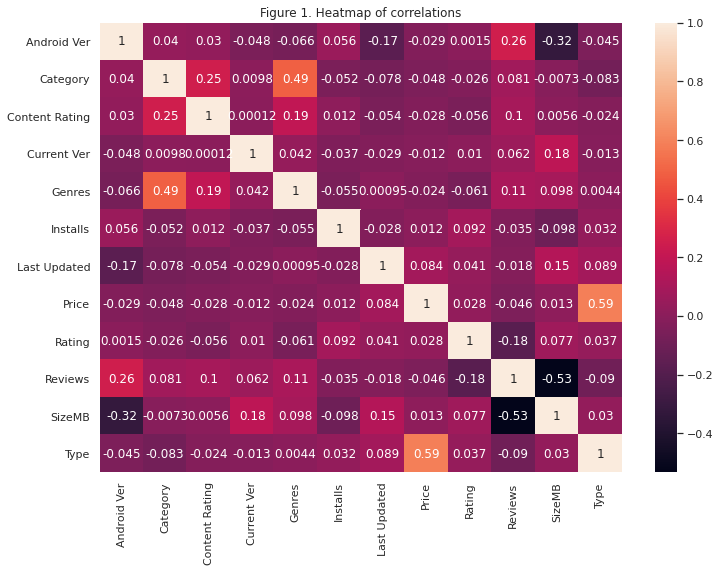

In [21]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
corr = ratings_corr.apply(lambda x: x.factorize()[0]).corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,annot=True).set(title='Figure 1. Heatmap of correlations')

#### A few things are apparent from the plot above:   

*Positive correlation*

`Price` and `Type`  - might be explained because of the direct association between type (signifying whether the app is paid or not) and price (which will be higher only for the paid type of the apps).

`Genres` and `Category` - as explained above in the table of features, the category is just a subset of genres, which thus will be removed from the dataset.

*Inverse correlation*

`SizeMB` and `Android Ver` - might be explained because of the technological progress, that is - the higher the application's android version, the less memory usually it takes because of greater compression algorithms and more iterations done over the application's algorithm.<br>

`Reviews` and `SizeMb` - might be explained because users usually dislike large-size applications and are downloading less of them.<br>

### `Genres` pre-processing

In [22]:
ratings_recent.groupby('Genres').count()
# these probably need to be pre-processed and hot-encoded

,Android Ver,App,Category,Content Rating,Current Ver,Installs,Last Updated,Price,Rating,Reviews,Size,SizeMB,Type
Genres,,,,,,,,,,,,,
Action,266,266,266,266,266,266,266,266,266,266,231,231,266
Action;Action & Adventure,12,12,12,12,12,12,12,12,12,12,11,11,12
Adventure,48,48,48,48,48,48,48,48,48,48,43,43,48
Adventure;Action & Adventure,11,11,11,11,11,11,11,11,11,11,11,11,11
Adventure;Brain Games,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Video Players & Editors,116,116,116,116,116,116,116,116,116,116,79,79,116
Video Players & Editors;Creativity,2,2,2,2,2,2,2,2,2,2,2,2,2
Video Players & Editors;Music & Video,2,2,2,2,2,2,2,2,2,2,0,0,2


In [23]:
# go over all entries of `genres` and extract each unique genre mentioned
# store all of them in a list
all_genres = []
for ind in ratings_recent.index:
    if ratings_recent['Genres'][ind]: 
        temp = ratings_recent['Genres'][ind].split(";")
        for val in temp: 
            if val not in all_genres: 
                all_genres.append(val)

In [24]:
print(len(all_genres))
# 53 of different unique genres
# 33 of different categories

52


In [25]:
print(all_genres[:10])
# add the columns to current df with 0s for now.
for genre in all_genres: 
    ratings_recent["gen_" +genre] = 0

['Events', 'Libraries & Demo', 'Medical', 'Tools', 'Personalization', 'Entertainment', 'Productivity', 'Video Players & Editors', 'Shopping', 'Lifestyle']


In [26]:
# go over each genre and if the app has this genre mentioed
# change 0 to 1
for ind in ratings_recent.index:
    if ratings_recent['Genres'][ind]:
        temp = ratings_recent['Genres'][ind].split(";")
        for val in temp: 
            ratings_recent['gen_'+val][ind] = 1

In [27]:
#ratings_recent.loc[ratings_recent['gen_Action'] == 1] # sanity check, we should see 
# quite a lot of apps subsetted

In [28]:
# uncomment to see an overlap between category and genres
#print(np.unique(ratings['Category']))
#print(all_genres[:10])

### `Content Rating` hot-encoding

In [29]:
ALL_ratings = pd.get_dummies(ratings_recent, columns=['Content Rating'], prefix=["rate_"] )
ALL_ratings = ALL_ratings.drop(labels = ['Last Updated', 'Category', 'Android Ver', 'Size','Genres','Current Ver'], axis = 1)

In [30]:
temp = ALL_ratings.drop(labels= ['App'], axis = 1)
temp = pd.DataFrame(temp.sum())
temp.columns = ['count']
temp.count = pd.to_numeric(temp['count'])

genres_to_drop = temp[temp['count']<40].index.values.tolist()
genres_to_drop = temp[temp['count']<40].index.values.tolist()
len(genres_to_drop) # we will remove the following genres 

9

In [31]:
ALL_ratings = ALL_ratings.drop(labels = genres_to_drop, axis = 1)
ALL_ratings.shape

(7283, 54)

In [32]:
# drop the NAs alltogether to ensure that we can run random forest. 
# we don' lose as much data with it. 
ALL_ratings=ALL_ratings.dropna()
# final size of the df is
ALL_ratings.shape

(5764, 54)

## 2.2. Modeling regression
<a class = 'anchor' id = 'modeling'></a>


Below, I use RFM and SVM to model regression. Because we deal with the continuous dependent variable, the accuracy rate is not possible as an objective metric. Therefore, I suggest using:

- **Mean Squared Error (MSE)** - which is often a go-to metric for regression models. It has an intuitive interpretation and is widely accepted. In our data, we don't have many outliers, so MSE's sensitivity to outliers is not a problem;


- **(1 - MAPE)** -  furthermore, I suggest complementing MSE with the proxy measurement for the accuracy rate of the continuous data. Specifically, Mean Absolute Percentage Error (MAPE) is an average of absolute percentage errors. Usually, you subtract this measurement from 100 to get an approximate accuracy. However, one should be aware that MAPE is asymmetric and reports higher errors if the predicted value is more than the actual and lower errors in vice versa.

It is important to mention that some of the variables are standard scaled to account for the discrepancy in the features' values. Specifically, below I apply `StandardScalar` on `Reviews`, `Installs`, `SizeMB` because of the very skewed values displayed in the graph below. It transforms the data in such a manner that it has a mean of 0 and a standard deviation of 1.

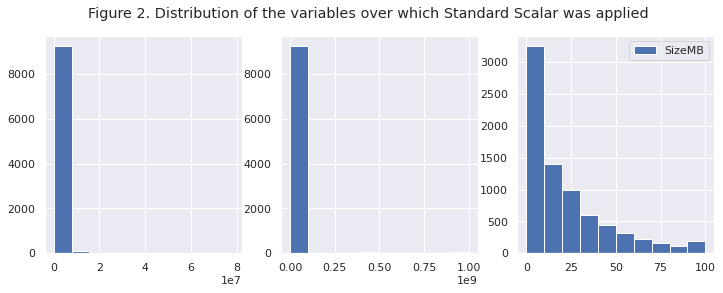

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))
fig.suptitle('Figure 2. Distribution of the variables over which Standard Scalar was applied')
ax1.hist(ratings['Reviews'], label = 'Reviews')
ax2.hist(ratings['Installs'], label = 'Installs')
ax3.hist(ratings['SizeMB'], label = 'SizeMB')
plt.legend()

In [34]:
# utility functions
def MSE(y_true_train, y_pred_train, y_true_test, y_pred_test): 
    '''Prints the MSE for training and test datasets'''
    print('Train Mean Squared Error is \n  ', mean_squared_error(y_true_train, y_pred_train))
    print('Test Mean Squared Error is \n  ', mean_squared_error(y_true_test, y_pred_test))

def MAPE_accu_proxy(y_true_train, y_pred_train, y_true_test, y_pred_test): 
    '''Prints the accuracy proxy for continuous variable'''
    errors_rf = abs(y_pred_train - y_true_train)
    mape_rf_train = 100 * (errors_rf / y_true_train)
    # calculate and display accuracy
    accuracy_rf_train = 100 - np.mean(mape_rf_train)
    print('Train accuracy \n  ', accuracy_rf_train)
    
    errors_rf = abs(y_pred_test - y_true_test)
    mape_rf = 100 * (errors_rf / y_true_test)
    # calculate and display accuracy
    accuracy_rf_test = 100 - np.mean(mape_rf)
    print('Test accuracy  \n  ', accuracy_rf_test )

In [35]:
#X = ALL_ratings[['Reviews', 'Installs', 'Type', 'Price', 'SizeMB']]
X = ALL_ratings.drop(labels = ['Rating', 'App'], axis = 1)
y = ALL_ratings['Rating']
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2)

In [36]:
scaler= StandardScaler()
# scaling the training data (fitting the parameters and transforming the values)
X_train['Reviews']=scaler.fit_transform(X_train['Reviews'].values.reshape(-1, 1))
X_train['Installs']=scaler.fit_transform(X_train['Installs'].values.reshape(-1, 1))
X_train['SizeMB']=scaler.fit_transform(X_train['SizeMB'].values.reshape(-1, 1))
# scaling the test data
X_test['Reviews']=scaler.fit_transform(X_test['Reviews'].values.reshape(-1, 1))
X_test['Installs']=scaler.fit_transform(X_test['Installs'].values.reshape(-1, 1))
X_test['SizeMB']=scaler.fit_transform(X_test['SizeMB'].values.reshape(-1, 1))

### 2.2.1. Random forest - hyperparameter tuning
<a class = 'anchor' id = 'rftuning'></a>
[Credits for code inspiration -- A. Cheng, Towards Data Science](https://towardsdatascience.com/machine-learning-step-by-step-6fbde95c455a)

In [37]:
# creating parameters for the CV grid search 
# self-explanatory:
min_samples_split = [4, 8, 16]
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
min_samples_leaf = [1, 2, 4, 8] # how many min samples needed on each leaf
# how many trees in estimator
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# num of features considered in splitting
max_features = ['auto', 'sqrt', 'log2']
# how to select samples for training each tree
bootstrap = [True, False]
# creating a grid for search
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [38]:
# creating a base model
rf = RandomForestRegressor()
# using 4-fold CV, search for best parameters
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=1, random_state=123, n_jobs =-1, scoring='neg_mean_squared_error')
# Fit search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [39]:
# rf_random.best_estimator_ # we will use this best estimator below

In [40]:
rf_best = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=1366, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [41]:
rf_best.fit(X_train,y_train)
y_pred_best_train = rf_best.predict(X_train)
y_pred_best_test = rf_best.predict(X_test)

In [42]:
MSE(y_train, y_pred_best_train, y_test, y_pred_best_test)
MAPE_accu_proxy(y_train, y_pred_best_train, y_test, y_pred_best_test)

Train Mean Squared Error is 
   0.08505491399570198
Test Mean Squared Error is 
   0.4039422506874775
Train accuracy 
   94.48548933634211
Test accuracy  
   87.77076237653931


Text(0.5, 0, 'Predicted rating')

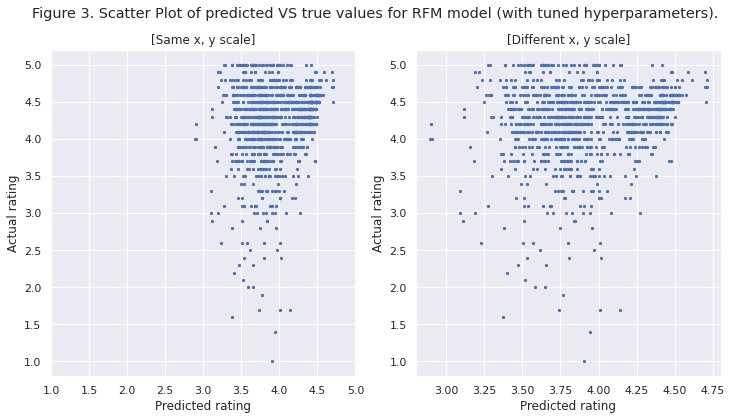

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (12,6))
fig.suptitle('Figure 3. Scatter Plot of predicted VS true values for RFM model (with tuned hyperparameters).')
ax1.set_title('[Same x, y scale]')
ax1.scatter(y_pred_best_test,y_test, s =5)
ax1.set_xlim([1,5])
ax1.set_ylabel('Actual rating')
ax1.set_xlabel('Predicted rating')

ax2.set_title('[Different x, y scale]')
ax2.scatter(y_pred_best_test,y_test, s =5)
ax2.set_ylabel('Actual rating')
ax2.set_xlabel('Predicted rating')

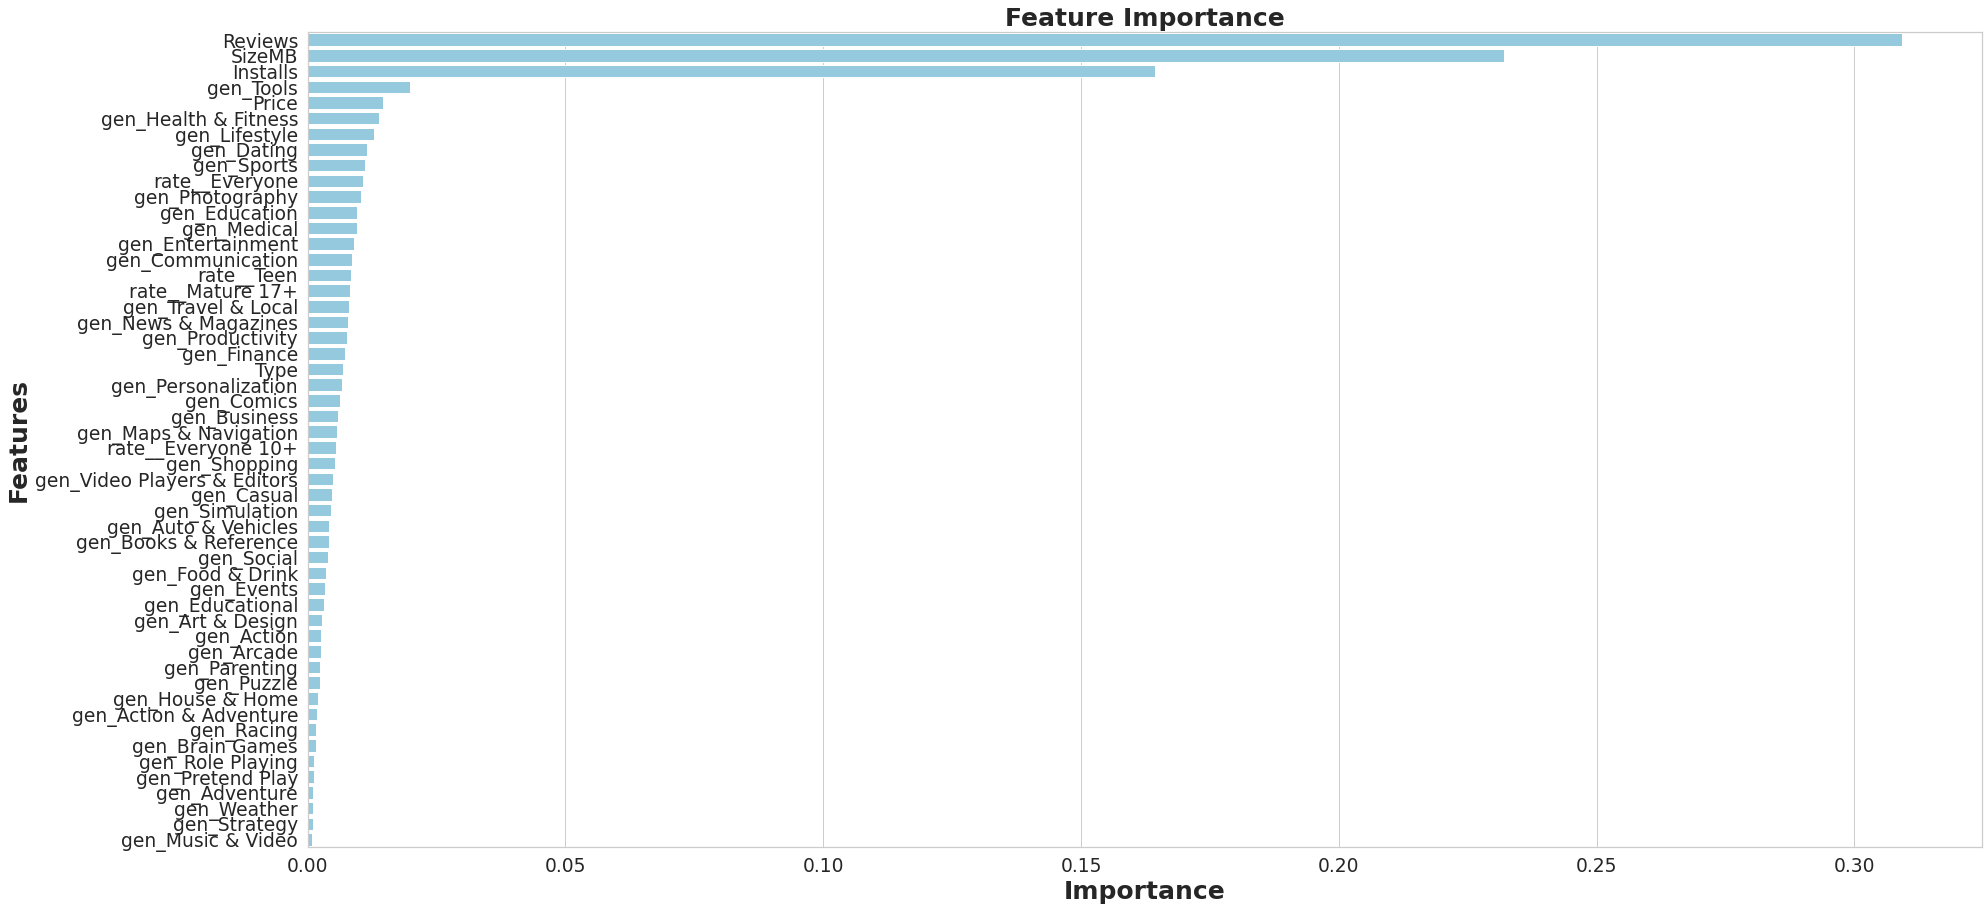

None

,Features,Gini-Importance
0,Reviews,0.309197
1,SizeMB,0.231975
2,Installs,0.164287
3,gen_Tools,0.019880
4,Price,0.014539


In [44]:
feats = {}
for feature, importance in zip(X_train.columns, rf_best.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances[:5])

### 2.2.2. Random forest + PCA (with tuned hyperparameters)
<a class = 'anchor' id = 'rfbasicpca'></a>
Given that we have many features, it is a good idea to perform Principal Component Analysis, a dimensionality-reduction technique that extracts the components that explain most variance in the data. PCA assumes a linear relationship between the features, which indeed must be a case in our scenario. 

Below we can see that just one PC can explain a large amount of variance. This can be explained by the fact that we have some correlated features (see Figure 1) such as `Installs` and `Reviews.` We also have a large amount of hot-encoded dummy variables that do not have many observations for each, so the variance explained by other components might indeed be lower.

#### PCA

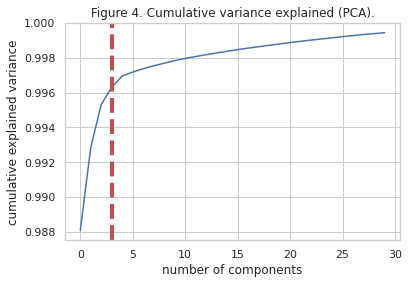

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.988082,0.988082
1,0.992862,0.004780
2,0.995320,0.002458
3,0.996302,0.000982
4,0.996953,0.000652


In [45]:
pca_ = PCA(n_components=30)
pca_.fit(X_train)
sns.set(style='whitegrid')
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca_.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Figure 4. Cumulative variance explained (PCA).')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=3, ymin=0, ymax=1)
display(plt.show())
evr = pca_.explained_variance_ratio_
cvr = np.cumsum(pca_.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(5))

In [46]:
# let's use just first three PCs as they explain > 99% of the variance in data
pca = PCA(n_components=3)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [47]:
rf_best.fit(X_train_pca,y_train)
y_pred_best_train_pca = rf_best.predict(X_train_pca)
y_pred_best_test_pca = rf_best.predict(X_test_pca)

In [48]:
MSE(y_train, y_pred_best_train_pca, y_test, y_pred_best_test_pca)
MAPE_accu_proxy(y_train, y_pred_best_train_pca, y_test, y_pred_best_test_pca)

Train Mean Squared Error is 
   0.06978750510546995
Test Mean Squared Error is 
   0.2904443604412552
Train accuracy 
   95.02160651674349
Test accuracy  
   89.5157221384896


Text(0.5, 0, 'Predicted rating')

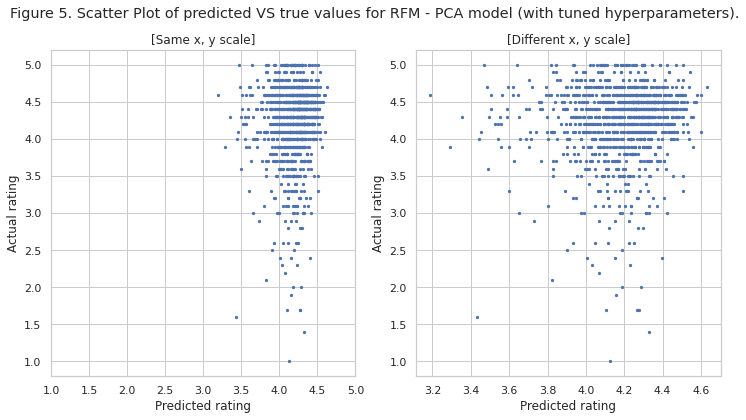

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (12,6))
fig.suptitle('Figure 5. Scatter Plot of predicted VS true values for RFM - PCA model (with tuned hyperparameters).')
ax1.set_title('[Same x, y scale]')
ax1.scatter(y_pred_best_test_pca,y_test, s =5)
ax1.set_xlim([1,5])
ax1.set_ylabel('Actual rating')
ax1.set_xlabel('Predicted rating')

ax2.set_title('[Different x, y scale]')
ax2.scatter(y_pred_best_test_pca,y_test, s =5)
ax2.set_ylabel('Actual rating')
ax2.set_xlabel('Predicted rating')

#### Seeing the importance of each feature

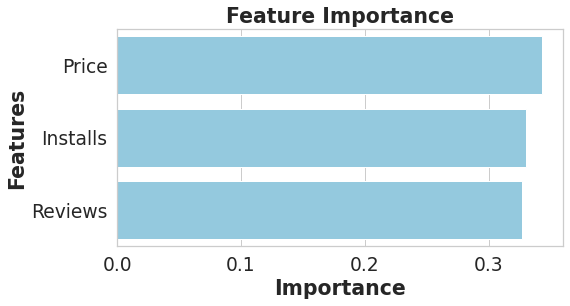

None

,Features,Gini-Importance
0,Price,0.343117
1,Installs,0.330036
2,Reviews,0.326846


In [50]:
feats = {}
for feature, importance in zip(X_train.columns, rf_best.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(8,4)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance',  weight = 'bold')
plt.ylabel('Features', weight = 'bold')
plt.title('Feature Importance',weight = 'bold')
display(plt.show())
display(importances)

### 2.2.3. Support Vector Machines -  hyperparameter tuning
<a id = 'svmhyper' class = 'anchor'></a>
I will use RBF kernel only given its great evidence for outperformace over other kernels ([Yekkehkhany1,Safari1, Homayouni, Hasanlou](https://www.int-arch-photogramm-remote-sens-spatial-inf-sci.net/XL-2-W3/281/2014/isprsarchives-XL-2-W3-281-2014.pdf), [Quora](https://www.quora.com/Why-does-RBF-kernel-generally-outperforms-linear-or-polynomial-kernels), [ResearchGate](https://www.researchgate.net/post/Diffference_between_SVM_Linear_polynmial_and_RBF_kernel)). Below I perform the CV search for the best parameters of this Support Vector Regression.

In [51]:
X = ALL_ratings.drop(labels = ['Rating', 'App'], axis = 1)
y = ALL_ratings['Rating']
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2)

In [52]:
SVR1 = svm.SVR()

In [53]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01,0.0001],
              'kernel': ['rbf']} 
grid = GridSearchCV(SVR1, param_grid, refit = True, verbose = 1, cv = 3)
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  1.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.0001], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [54]:
grid.best_params_

{'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}

Train Mean Squared Error is 
   0.2440614631066688
Test Mean Squared Error is 
   0.2530365285241373
Train accuracy 
   91.03261790770088
Test accuracy  
   90.33541320247217


Text(0.5, 0, 'Predicted rating')

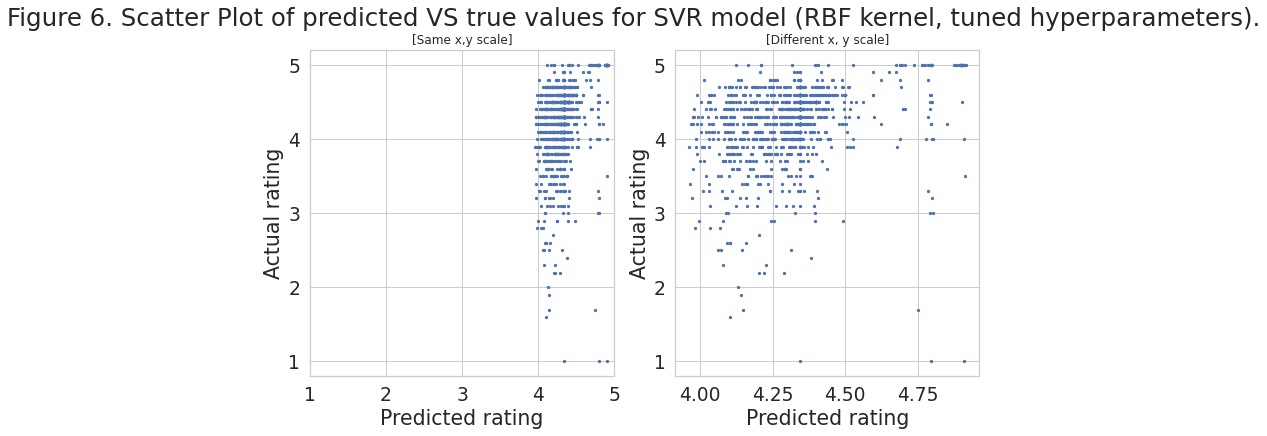

In [55]:
y_pred_test_SVR1 = grid.predict(X_test)
y_pred_train_SVR1 = grid.predict(X_train)

MSE(y_train, y_pred_train_SVR1, y_test, y_pred_test_SVR1)
MAPE_accu_proxy(y_train, y_pred_train_SVR1, y_test, y_pred_test_SVR1)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (12,6))
fig.suptitle('Figure 6. Scatter Plot of predicted VS true values for SVR model (RBF kernel, tuned hyperparameters).')
ax1.set_title(f'[Same x,y scale]', fontsize =12  )
ax1.scatter(y_pred_test_SVR1,y_test, s =5)
ax1.set_xlim([1,5])
ax1.set_ylabel('Actual rating')
ax1.set_xlabel('Predicted rating')

ax2.set_title(f'[Different x, y scale]', fontsize =12 )
ax2.scatter(y_pred_test_SVR1,y_test, s =5)
ax2.set_ylabel('Actual rating')
ax2.set_xlabel('Predicted rating')

### 2.2.4. Support Vector Machines + PCA (with tuned hyperparameters)
<a id = 'svmhyperpca' class = 'anchor'></a>

In [56]:
pca = PCA(n_components=3)
pca.fit(X_train)
X_train_scaled_pca = pca.transform(X_train)
X_test_scaled_pca = pca.transform(X_test)

In [57]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01,0.0001],
              'kernel': ['rbf']} 
grid1 = GridSearchCV(SVR1, param_grid, refit = True, verbose = 1, cv = 3)
# fitting the model for grid search
grid1.fit(X_train_scaled_pca, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   52.3s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.0001], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [58]:
grid1.best_params_

{'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}

Train Mean Squared Error is 
   0.24416350676411377
Test Mean Squared Error is 
   0.25281676825438104
Train accuracy 
   91.02057085382154
Test accuracy  
   90.33335156512533


Text(0.5, 0, 'Predicted rating')

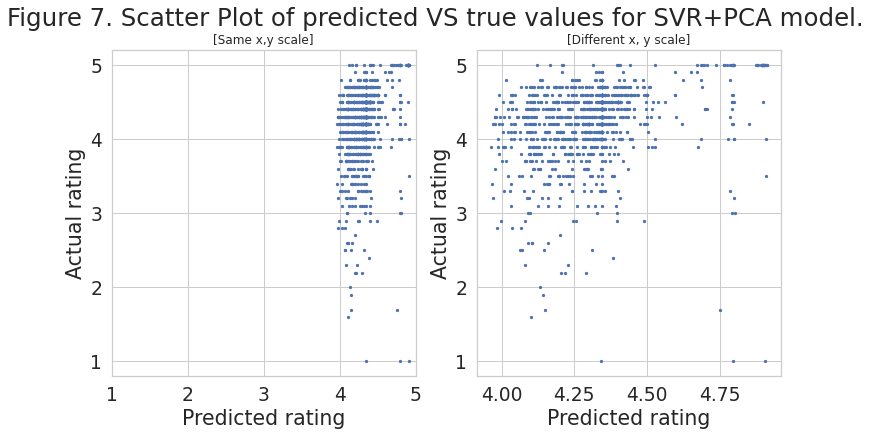

In [59]:
y_pred_test_pca_SVR1 = grid1.predict(X_test_scaled_pca)
y_pred_train_pca_SVR1 = grid1.predict(X_train_scaled_pca)

MSE(y_train, y_pred_train_pca_SVR1, y_test, y_pred_test_pca_SVR1)
MAPE_accu_proxy(y_train, y_pred_train_pca_SVR1, y_test, y_pred_test_pca_SVR1)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (12,6))
fig.suptitle('Figure 7. Scatter Plot of predicted VS true values for SVR+PCA model.')

ax1.scatter(y_pred_test_SVR1,y_test, s =5)
ax1.set_xlim([1,5])
ax1.set_ylabel('Actual rating')
ax1.set_xlabel('Predicted rating')
ax1.set_title(f'[Same x,y scale]', fontsize =12  )
ax2.set_title(f'[Different x, y scale]', fontsize =12 )
ax2.scatter(y_pred_test_SVR1,y_test, s =5)
ax2.set_ylabel('Actual rating')
ax2.set_xlabel('Predicted rating')

### 2.2.5. SUMMARY 
<a id = 'sum1' class = 'anchor'></a>

| Model | Hyperparameters | MSE train | MSE test | Accuracy train* | Accuracy test*| Comment |
|---|---|---|---|---|---|---|
|RFM|max_depth=30, max_features='sqrt', min_samples_leaf=1,min_samples_split=4,n_estimators=1366|0.084|0.23|94.53|90.71| Hyperparameters were chosen thought 4-fold grid CV search|
|RFM+PCA|same as above|0.084|0.33|94.32|88.21||
|SVM|'C'= 0.1, 'gamma'= 0.0001, 'kernel': 'rbf'|0.23|0.3|91.2|89.68| Hyperparameters were chosen thought 4-fold grid CV search|
|SVM+PCA|same as above | 0.23|0.296|91.19|89.66| Hyperparameters were chosen thought 4-fold grid CV search|
|*: for regression, accuracy is 1-MAPE|

The above table displays all the results for the regression models. I *chose hyperparameters with the 4-fold CV search to prevent overfitting.* (Find Appendix C, simpler models (without CV search) that have cases of serious overfitting because of the lack of CV.)

Given the results above, it seems apparent that **there is no large discrepancy between the models**. Judging from the MSE errors (training MSE is a lot lower than test one), it looks like *RFM has a higher tendency to overfit than SVMs.* I would suggest **using SVM over the RFM** for this specific scenario. Here we have many hot-encoded variables, resulting in sparse data, and SVMs usually perform better.

It is important to note that using random forests has its own advantages, relevant to the scenario. Using this technique, I extracted the features by the degree of importance to a model in `RFM` and `RFM+PCA` models. These RFM variations **emphasize the importance of price and reviews,** which can be rationalized by the fact that: (a) usually the price is a proxy for quality; (b) the number of reviews might be correlated with the average better rating. Also, there must be a *reinforcement loop - more and more people download the app if it has more installs (higher reputation).*

Furthermore, we can see that all the *models predicted well the values are that are close to the mean (3.5-4.5 of rating) and underperformed on the lower values (see figures 7,6,5,3).* This might be explained because the lower rating does not have much of the observations; hence the model didn't learn to generalize well for this subset of data. I tried resolving this problem by upsampling and undersampling the data (Appendices A, B), but it did not yield better results. The reason for this might be is that there is little data for that range. Even though the model does not generalize superbly well for lower ratings, I would still argue that the SVM model is greatly beneficial because it has great prediction power for the values around the most important for businesses range (between 3.5-4.5).

*Note: I created the table before the final run of the notebook. Hence the results displayed might have an insignificant difference from what is displayed during the analysis.*

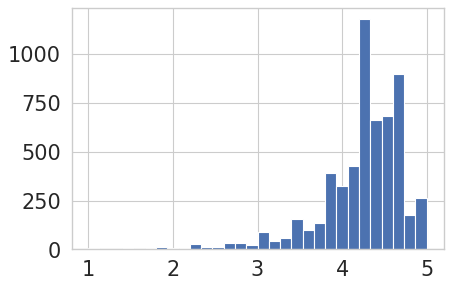

In [60]:
plt.figure(figsize=(6, 4), dpi=80)
plt.hist(y, bins = 30)
plt.show()

# 3. Modeling classification <a id = 'modeling2' class = 'anchor'></a>
Below I define the success of the application as a function of two criteria. First, the application rating should be higher than the median (that is, the app is better than the other half). Second, there are at least 1000 users.

Furthermore, it is essential to note another difference in this type of modeling. Because of the question that we are aiming to answer ("Can I use ML to predicting the app's success before launch?"), I only include pre-launch features to be in the feature set. This means that features like `Installs` `Reviews` are removed.

In [61]:
def filter_(row, installs_threshold = 1000, rating_threshold=np.median(ALL_ratings['Rating'])):
    if row['Reviews'] >= installs_threshold and row['Rating'] >= rating_threshold :
        val = 1
    else:
        val = 0
    return val

In [62]:
ALL_ratings['successful?'] = ALL_ratings.apply(filter_, axis=1)

In [63]:
print(ALL_ratings[ALL_ratings['successful?'] == 1].shape, ALL_ratings[ALL_ratings['successful?'] == 0].shape)

(2198, 55) (3566, 55)


In [64]:
ALL_ratings.columns

Index(['App', 'Installs', 'Price', 'Rating', 'Reviews', 'SizeMB', 'Type',
       'gen_Events', 'gen_Medical', 'gen_Tools', 'gen_Personalization',
       'gen_Entertainment', 'gen_Productivity', 'gen_Video Players & Editors',
       'gen_Shopping', 'gen_Lifestyle', 'gen_Finance', 'gen_Comics',
       'gen_Communication', 'gen_Art & Design', 'gen_Pretend Play',
       'gen_Auto & Vehicles', 'gen_Books & Reference', 'gen_Business',
       'gen_Dating', 'gen_Education', 'gen_Brain Games', 'gen_Music & Video',
       'gen_Food & Drink', 'gen_Health & Fitness', 'gen_House & Home',
       'gen_Adventure', 'gen_Action & Adventure', 'gen_Arcade', 'gen_Casual',
       'gen_Strategy', 'gen_Action', 'gen_Puzzle', 'gen_Sports', 'gen_Racing',
       'gen_Simulation', 'gen_Role Playing', 'gen_Educational', 'gen_Social',
       'gen_Photography', 'gen_Travel & Local', 'gen_Parenting', 'gen_Weather',
       'gen_News & Magazines', 'gen_Maps & Navigation', 'rate__Everyone',
       'rate__Everyone 10+', 

In [65]:
X = ALL_ratings.drop(labels = ['Rating','successful?', 'Installs', 'Reviews', 'App'], axis = 1)
y = ALL_ratings['successful?']
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2)

In [66]:
scaler= StandardScaler()
# scaling the training data (fitting the parameters and transforming the values)

X_train['SizeMB']=scaler.fit_transform(X_train['SizeMB'].values.reshape(-1, 1))
X_test['SizeMB']=scaler.fit_transform(X_test['SizeMB'].values.reshape(-1, 1))

### 2.3.1. Random forest - hyperparameter tuning
<a id = 'r_clf' class = 'anchor'></a> 
Same process but different type of Random Forest -- Classifier.



In [67]:
# create a base model
rf_clf = RandomForestClassifier()
# using 4-fold CV, search for best parameters
rf_random_clf = RandomizedSearchCV(estimator = rf_clf, param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=1, random_state=123, n_jobs =-1, scoring='neg_mean_squared_error')
# Fit the random search model
rf_random_clf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [68]:
rf_random_clf.best_params_

{'n_estimators': 733,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 20,
 'bootstrap': True}

In [69]:
rf_random_clf.fit(X_train,y_train)
y_pred_best_train = rf_random_clf.predict(X_train)
y_pred_best_test = rf_random_clf.predict(X_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.2min finished


In [70]:
print('Test'.upper())
print(classification_report(y_test, y_pred_best_test))
print('Train'.upper())
print(classification_report(y_train, y_pred_best_train))

TEST
              precision    recall  f1-score   support

           0       0.69      0.85      0.76       718
           1       0.61      0.37      0.46       435

    accuracy                           0.67      1153
   macro avg       0.65      0.61      0.61      1153
weighted avg       0.66      0.67      0.65      1153

TRAIN
              precision    recall  f1-score   support

           0       0.77      0.96      0.85      2848
           1       0.88      0.53      0.66      1763

    accuracy                           0.79      4611
   macro avg       0.82      0.74      0.76      4611
weighted avg       0.81      0.79      0.78      4611



### 2.3.2. Random forest + PCA (with tuned hyperparameters)
<a id = 'rfbasicpca_clf' class = 'anchor'></a> 

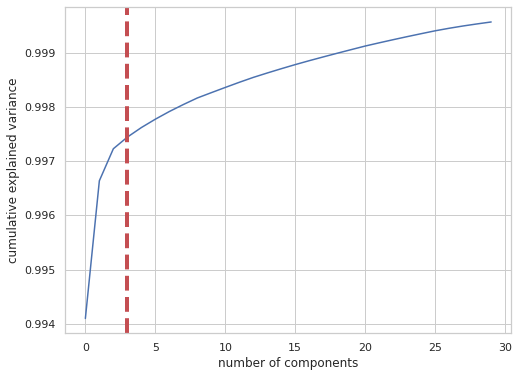

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.994097,0.994097
1,0.996638,0.002541
2,0.997228,0.000591
3,0.997443,0.000215
4,0.997619,0.000176
5,0.997774,0.000154
6,0.997915,0.000142
7,0.998044,0.000129
8,0.998165,0.000121
9,0.998263,0.000098


In [71]:
pca_ = PCA(n_components=30)
pca_.fit(X_train)
sns.set(style='whitegrid')
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca_.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=3, ymin=0, ymax=1)
display(plt.show())
evr = pca_.explained_variance_ratio_
cvr = np.cumsum(pca_.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

In [72]:
pca = PCA(n_components=3)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [73]:
rf_random_clf.fit(X_train_pca,y_train)
y_pred_best_train_pca = rf_random_clf.predict(X_train_pca)
y_pred_best_test_pca = rf_random_clf.predict(X_test_pca)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.0min finished


In [74]:
print('Train'.upper())
print(classification_report(y_train, y_pred_best_train_pca))
print('-------------------')
print('Test'.upper())
print(classification_report(y_test, y_pred_best_test_pca))

TRAIN
              precision    recall  f1-score   support

           0       0.73      0.95      0.83      2848
           1       0.85      0.44      0.58      1763

    accuracy                           0.76      4611
   macro avg       0.79      0.70      0.70      4611
weighted avg       0.78      0.76      0.73      4611

-------------------
TEST
              precision    recall  f1-score   support

           0       0.68      0.88      0.77       718
           1       0.61      0.31      0.41       435

    accuracy                           0.66      1153
   macro avg       0.64      0.59      0.59      1153
weighted avg       0.65      0.66      0.63      1153



### 2.3.3. Support Vector Machines - hyperparameter tuning
<a id = 'svmhyper_clf' class = 'anchor'></a> 
Same process as in 2.2., but different type of SVM - Support Vector Classifier.

In [75]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01,0.0001],
              'kernel': ['rbf']} 
grid_clf = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 1, cv = 3)
# fitting the model for grid search
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  1.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.0001], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [76]:
grid_clf.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [77]:
y_pred_test_SVC = grid_clf.predict(X_test)
y_pred_train_SVC = grid_clf.predict(X_train)
print('Train'.upper())
print(classification_report(y_train, y_pred_train_SVC))
print('-------------------')
print('Test'.upper())
print(classification_report(y_test, y_pred_test_SVC))

TRAIN
              precision    recall  f1-score   support

           0       0.73      0.90      0.80      2848
           1       0.73      0.47      0.57      1763

    accuracy                           0.73      4611
   macro avg       0.73      0.68      0.69      4611
weighted avg       0.73      0.73      0.71      4611

-------------------
TEST
              precision    recall  f1-score   support

           0       0.70      0.85      0.77       718
           1       0.61      0.40      0.48       435

    accuracy                           0.68      1153
   macro avg       0.66      0.62      0.62      1153
weighted avg       0.67      0.68      0.66      1153




### 2.3.4. Support Vector Machines + PCA (with tuned hyperparameters)
<a id = 'svmhyperpca_clf' class = 'anchor'></a> 

In [78]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01,0.0001],
              'kernel': ['rbf']} 
grid_clf_pca = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 1, cv = 3)
# fitting the model for grid search
grid_clf_pca.fit(X_train_pca, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   31.0s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.0001], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [79]:
grid_clf_pca.best_params_

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [80]:
y_pred_test_pca_SVC = grid_clf_pca.predict(X_test_pca)
y_pred_train_pca_SVC = grid_clf_pca.predict(X_train_pca)
print('Train'.upper())
print(classification_report(y_train, y_pred_train_pca_SVC))
print('-------------------')
print('Test'.upper())
print(classification_report(y_test, y_pred_test_pca_SVC))

TRAIN
              precision    recall  f1-score   support

           0       0.67      0.89      0.76      2848
           1       0.62      0.28      0.39      1763

    accuracy                           0.66      4611
   macro avg       0.64      0.59      0.57      4611
weighted avg       0.65      0.66      0.62      4611

-------------------
TEST
              precision    recall  f1-score   support

           0       0.67      0.87      0.76       718
           1       0.57      0.29      0.39       435

    accuracy                           0.65      1153
   macro avg       0.62      0.58      0.57      1153
weighted avg       0.63      0.65      0.62      1153



### 2.3.5. SUMMARY
<a id = 'sum1_clf' class = 'anchor'></a> 


|Model  | Hyperparameters | Accuracy train | Accuracy test | Comment| 
|---| --- |--- | --- | ---| 
|RFC| n_estimators'=  733,'min_samples_split'= 4,'min_samples_leaf'= 1, 'max_features'= 'log2','max_depth'= 20,'bootstrap'= True |0.79 | 0.67 | Hyperparameters chosen via 3-fold CV grid search| 
|RFC + PCA| same as above |0.76 | 0.66 | same as above|
|SVM|'C'= 1, 'gamma'= 1, 'kernel'= 'rbf' |0.73 | 0.68 | Hyperparameters chosen via 3-fold CV grid search|
|SVM + PCA| 'C' = 10, 'gamma'=  1, 'kernel'= 'rbf' |0.66 | 0.65 | Hyperparameters chosen via 3-fold CV grid search|

The above table shows that again there is no much discrepancy among models' results. Furthermore, RFC seems to have a higher tendency of overfitting. 

In this scenario, false positives are a lot worse than false negatives because once a potential founder knows that his app might be successful, they are likely to spend a lot of capital on it. In the end, it could appear to be a false positive. This means that precision for 1s (success) is of greater importance than recall. Judging from the classification reports above, it seems apparent that 3/4 models (all but SVM+PCA) have the same precision of 0.61. Usual SVC, however, also has a precision score of 0.7 for 0s -- the highest out of all. 

Given the above, I suggest using **SVM over the RFM for this problem.** Also, given that ultimate accuracy rates are relatively low (vary near 0.67), it is essential to emphasize that this classification problem requires more data to answer the posed question. Having only price, genres, and size is not sufficient to explain the success. Other information about the developer and their experience is likely necessary to improve the accuracy of this classification problem.

# 3. Summary
<a id = 'summaryfinal' class = 'anchor'></a>

Above I utilized RFM and SVM to analyze the success of the applications on the Google Play Market. In both of the cases, SVM performed better than RFM, which makes sense given the high sparsity of the feature dataset. All in all, it is valid to conclude that the best method is very dependent on the dataset. RFM is likely to perform better in multiple class data, but here we only had 2. As I said before, having RFM is still of great benefit as it allows us to extract essential for success features. 

**Recommendations for future analysis:**

- Complement this quantitive analysis of the app's success with a qualitative analysis of the user reviews. For this, the second part of the Kaggle dataset could be used. Here, the topic extraction techniques such as LDA could be used along with the sentiment analysis to determine which aspects of the app have a more positive outlook and which elements of the app founders should avoid.

- Scrap more data from the Google Play Store about the developer to improve the classification problem's accuracy score.

# Appendix 
<a id = 'appendix' class = 'anchor'></a>

Below are: 

- (a) Appendix A, B  my attempts to deal with the imbalance in data - specifically, the distribution of ratings is skewed to the left (with higher scores occurring more often). I tried undersampling the more common observations and upsampling the less common. Unfortunately, neither of these techniques yielded better results, hence it goes into the appendix. 

- (b) Appendix C, D the simpler models I tried before running the CV grid search. One can see that they underperform any of the other models. 

## Appendix A. Dealing with inbalance - undersampling the majority
<a class = 'anchor' id = 'inbalance'></a>

[Credits for code inpiration - elite data science](https://elitedatascience.com/imbalanced-classes)

In [ ]:
#X = ALL_ratings[['Reviews', 'Installs', 'Type', 'Price', 'SizeMB']]
X = ALL_ratings.drop(labels = ['successful?'], axis = 1)
y = ALL_ratings['Rating']
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2)
scaler= StandardScaler()
# scaling the training data (fitting the parameters and transforming the values)
X_train['Reviews']=scaler.fit_transform(X_train['Reviews'].values.reshape(-1, 1))
X_train['Installs']=scaler.fit_transform(X_train['Installs'].values.reshape(-1, 1))
X_train['SizeMB']=scaler.fit_transform(X_train['SizeMB'].values.reshape(-1, 1))
# scaling the test data
X_test['Reviews']=scaler.fit_transform(X_test['Reviews'].values.reshape(-1, 1))
X_test['Installs']=scaler.fit_transform(X_test['Installs'].values.reshape(-1, 1))
X_test['SizeMB']=scaler.fit_transform(X_test['SizeMB'].values.reshape(-1, 1))

In [82]:
ALL_ratings[ALL_ratings['Rating'] < 3.9].shape

(939, 55)

In [83]:
ratings_minority1 = ALL_ratings[(ALL_ratings['Rating'] < 3.9)& (ALL_ratings['Rating'] > 2.9)]
print(ratings_minority1.shape)
ratings_minority2 = ALL_ratings[ALL_ratings['Rating'] <= 2.9]
print(ratings_minority2.shape)
ratings_majority = ALL_ratings[ALL_ratings['Rating'] >= 3.9]
print(ratings_majority.shape)

(751, 55)
(188, 55)
(4825, 55)


In [84]:
ratings_majority_undersampled = resample(ratings_majority, replace = True, n_samples =ratings_minority1.shape[0], random_state = 123)
ratings_undersampled = pd.concat([ratings_minority1 , ratings_minority2,ratings_majority_undersampled])
ratings_undersampled.shape

(1690, 55)

In [85]:
#X = ALL_ratings[['Reviews', 'Installs', 'Type', 'Price', 'SizeMB']]
X_undersampled = ratings_undersampled.drop(labels = ['Rating', 'App'], axis = 1) 
y_undersampled  = ratings_undersampled['Rating']
X_train_undersampled ,X_test_undersampled ,y_train_undersampled ,y_test_undersampled  = train_test_split(X_undersampled ,y_undersampled , test_size=0.2)


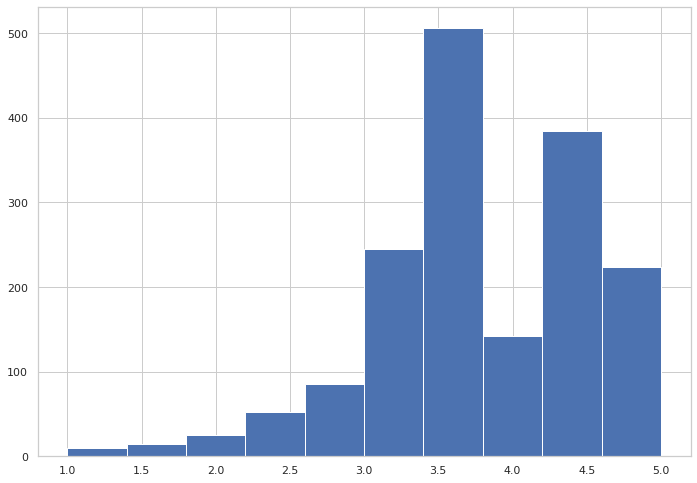

In [86]:
plt.hist(y_undersampled)
plt.show()

In [87]:
scaler= StandardScaler()
# scaling the training data (fitting the parameters and transforming the values)

X_train_undersampled['Reviews']=scaler.fit_transform(X_train_undersampled['Reviews'].values.reshape(-1, 1))
X_train_undersampled['Installs']=scaler.fit_transform(X_train_undersampled['Installs'].values.reshape(-1, 1))
X_train_undersampled['SizeMB']=scaler.fit_transform(X_train_undersampled['SizeMB'].values.reshape(-1, 1))

X_test_undersampled['Reviews']=scaler.fit_transform(X_test_undersampled['Reviews'].values.reshape(-1, 1))
X_test_undersampled['Installs']=scaler.fit_transform(X_test_undersampled['Installs'].values.reshape(-1, 1))
X_test_undersampled['SizeMB']=scaler.fit_transform(X_test_undersampled['SizeMB'].values.reshape(-1, 1))

In [88]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_undersampled = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                               cv = 4, verbose=2, random_state=42, n_jobs =-1, scoring='neg_mean_squared_error')
# Fit the random search model
rf_random_undersampled.fit(X_train_undersampled, y_train_undersampled)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 353 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.9min finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [89]:
# running the best estimaor model
rf_best_undersampled = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=1788, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [90]:
rf_best_undersampled.fit(X_train_undersampled,y_train_undersampled)
y_pred_best_undersampled_train = rf_best_undersampled.predict(X_train_undersampled)
y_pred_best_undersampled_test = rf_best_undersampled.predict(X_test_undersampled)

In [91]:
MSE(y_train_undersampled, y_pred_best_undersampled_train, y_test_undersampled, y_pred_best_undersampled_test)
MAPE_accu_proxy(y_train_undersampled, y_pred_best_undersampled_train, y_test_undersampled, y_pred_best_undersampled_test)

Train Mean Squared Error is 
   0.15763108437913778
Test Mean Squared Error is 
   0.43441977336028936
Train accuracy 
   90.90336753989507
Test accuracy  
   85.56319904047237


## Appendix B. Dealing with inbalance - undersampling the majority (with PCA)
<a class = 'anchor' id = 'inbalance2'></a>

In [92]:
pca = PCA(n_components=3)
pca.fit(X_train_undersampled)
X_train_scaled_pca = pca.transform(X_train_undersampled)
X_test_scaled_pca = pca.transform(X_test_undersampled)

rf_best_undersampled.fit(X_train_scaled_pca,y_train_undersampled)
y_pred_best_undersampled_train = rf_best_undersampled.predict(X_train_scaled_pca)
y_pred_best_undersampled_test = rf_best_undersampled.predict(X_test_scaled_pca)

In [93]:
MSE(y_train_undersampled, y_pred_best_undersampled_train, y_test_undersampled, y_pred_best_undersampled_test)
MAPE_accu_proxy(y_train_undersampled, y_pred_best_undersampled_train, y_test_undersampled, y_pred_best_undersampled_test)


Train Mean Squared Error is 
   0.16856449080887953
Test Mean Squared Error is 
   0.42431057385469956
Train accuracy 
   90.26016577323726
Test accuracy  
   85.6962231209189


## Appendix C. Random forest basic
<a class = 'anchor' id = 'rfbasic'></a>

[Credits for the code inspiration](https://stackoverflow.com/questions/53782169/random-forest-tuning-with-randomizedsearchcv).

In [101]:
#X = ALL_ratings[['Reviews', 'Installs', 'Type', 'Price', 'SizeMB']]
X = ALL_ratings.drop(labels = ['successful?', 'App', 'Rating'], axis = 1)
y = ALL_ratings['Rating']
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2)
scaler= StandardScaler()
# scaling the training data (fitting the parameters and transforming the values)
X_train['Reviews']=scaler.fit_transform(X_train['Reviews'].values.reshape(-1, 1))
X_train['Installs']=scaler.fit_transform(X_train['Installs'].values.reshape(-1, 1))
X_train['SizeMB']=scaler.fit_transform(X_train['SizeMB'].values.reshape(-1, 1))
# scaling the test data
X_test['Reviews']=scaler.fit_transform(X_test['Reviews'].values.reshape(-1, 1))
X_test['Installs']=scaler.fit_transform(X_test['Installs'].values.reshape(-1, 1))
X_test['SizeMB']=scaler.fit_transform(X_test['SizeMB'].values.reshape(-1, 1))

In [102]:
rf=RandomForestRegressor()
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [103]:
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)


In [104]:
MSE(y_train, y_pred_train, y_test, y_pred_test)
MAPE_accu_proxy(y_train, y_pred_train, y_test, y_pred_test)

Train Mean Squared Error is 
   0.03311456197753149
Test Mean Squared Error is 
   0.3733099245446669
Train accuracy 
   96.74717282930352
Test accuracy  
   88.31085252633747


## Appendix D. Support Vector Machines basic
<a class = 'anchor' id = 'svm'></a>

In [105]:
SVR1 = svm.SVR()
SVR1.fit(X_train,y_train)
y_pred_test_SVR1 = SVR1.predict(X_test)
y_pred_train_SVR1 = SVR1.predict(X_train)

In [106]:
MSE(y_train, y_pred_train_SVR1, y_test, y_pred_test_SVR1)
MAPE_accu_proxy(y_train, y_pred_train_SVR1, y_test, y_pred_test_SVR1)

Train Mean Squared Error is 
   0.2757228610161216
Test Mean Squared Error is 
   0.2718260179844148
Train accuracy 
   89.97795568549348
Test accuracy  
   89.98146943374536
